In [77]:
import pandas as pd

data = pd.read_csv('NVidia_stock_history.csv')


data = data[['Date', 'Close']]

data 


,Date,Close
0,1999-01-22 00:00:00-05:00,0.037621
1,1999-01-25 00:00:00-05:00,0.041562
2,1999-01-26 00:00:00-05:00,0.038337
3,1999-01-27 00:00:00-05:00,0.038218
4,1999-01-28 00:00:00-05:00,0.038098
...,...,...
6437,2024-08-22 00:00:00-04:00,123.739998
6438,2024-08-23 00:00:00-04:00,129.369995
6439,2024-08-26 00:00:00-04:00,126.459999
6440,2024-08-27 00:00:00-04:00,128.300003


In [78]:
# Convert Date column to datetime format
data['Date'] = pd.to_datetime(data['Date'], utc=True).dt.tz_localize(None)

# Set Date as index for time-series operations
data.set_index('Date', inplace=True)

data.head()


,Close
Date,
1999-01-22 05:00:00,0.037621
1999-01-25 05:00:00,0.041562
1999-01-26 05:00:00,0.038337
1999-01-27 05:00:00,0.038218
1999-01-28 05:00:00,0.038098


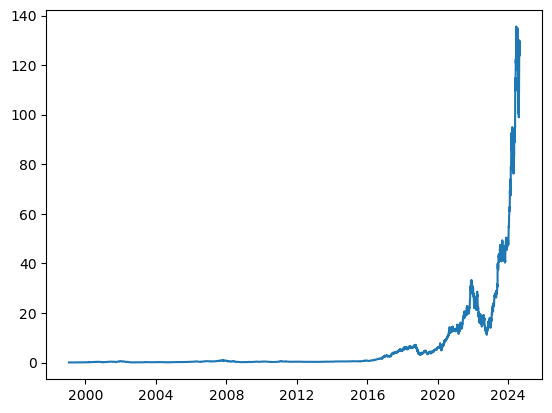

In [79]:
import matplotlib.pyplot as plt

plt.plot(data.index, data['Close'])


In [80]:
import numpy as np

def data_to_windowed_df(data, first_date, last_date, n=3):
    # Filter data by date range
    mask = (data.index >= first_date) & (data.index <= last_date)
    filtered_data = data[mask].copy()
    
    # Extract Close prices as numpy array for easier manipulation
    close_prices = filtered_data['Close'].values
    
    # Create lists to store features (X) and targets (y)
    X = []  # Features: sequences of n days
    y = []  # Target: next day's price
    dates = []  # Dates corresponding to each target
    
    # Create sliding windows
    # For each position i, use prices[i:i+n] to predict price[i+n]
    for i in range(len(close_prices) - n):
        # Features: n consecutive days
        X.append(close_prices[i:i+n])
        # Target: the next day's price (day n+1)
        y.append(close_prices[i+n])
        # Store the date of the target
        dates.append(filtered_data.index[i+n])
    
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
  
    # Each column represents a day in the window (Day_0, Day_1, ..., Day_n-1)
    feature_columns = [f'Day_{i}' for i in range(n)]
    windowed_df = pd.DataFrame(X, columns=feature_columns)
    
    # Add target column
    windowed_df['Target'] = y
    
    # Add date column
    windowed_df['Date'] = dates
    
    return windowed_df

windowed_df = data_to_windowed_df(data, '2024-01-01', '2025-12-20')


In [81]:

def windowed_data_to_data_x_y(windowed_df):

    dates = windowed_df['Date'].values
    
    numeric_df = windowed_df.drop(columns=['Date'])
    df_as_np = numeric_df.to_numpy()
    
    middle_matrix = df_as_np[:, :-1] 
    x = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))
    
    y = df_as_np[:, -1]
    
    return dates, x.astype(np.float32), y.astype(np.float32)

dates, x, y = windowed_data_to_data_x_y(windowed_df)

dates.shape, x.shape, y.shape


((163,), (163, 3, 1), (163,))

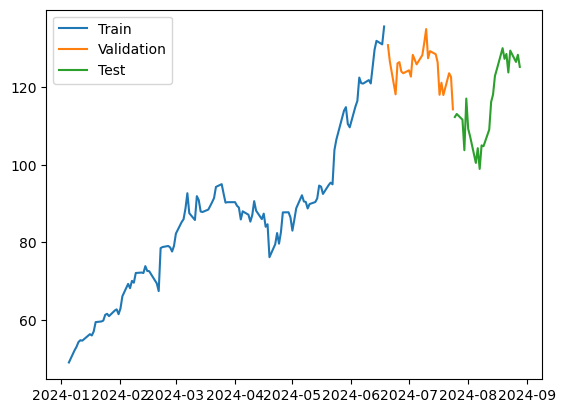

In [82]:
# Data split: 70% training, 15% validation, 15% testing
q_70 = int(len(dates) * 0.7)   # 70% mark
q_85 = int(len(dates) * 0.85)  # 85% mark (70% + 15%)

# Training data (70%)
dates_train, x_train, y_train = dates[:q_70], x[:q_70], y[:q_70]

# Validation data (15%)
dates_val, x_val, y_val = dates[q_70:q_85], x[q_70:q_85], y[q_70:q_85]

# Testing data (15%)
dates_test, x_test, y_test = dates[q_85:], x[q_85:], y[q_85:]

plt.plot(dates_train, y_train)
plt.plot (dates_val, y_val)
plt.plot (dates_test, y_test)
plt.legend(['Train', 'Validation', 'Test'])


In [83]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    LSTM(64, input_shape=(3, 1)),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(
    loss='mse',
    optimizer=Adam(learning_rate=0.001),
    metrics=['mean_absolute_error']
)

model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=100
)

Epoch 1/100
4/4 [==============================] - 1s 47ms/step - loss: 7721.8330 - mean_absolute_error: 85.7668 - val_loss: 15574.6094 - val_mean_absolute_error: 124.7095
Epoch 2/100
4/4 [==============================] - 0s 4ms/step - loss: 7633.3350 - mean_absolute_error: 85.2490 - val_loss: 15458.6719 - val_mean_absolute_error: 124.2438
Epoch 3/100
4/4 [==============================] - 0s 4ms/step - loss: 7558.9854 - mean_absolute_error: 84.8130 - val_loss: 15354.6406 - val_mean_absolute_error: 123.8245
Epoch 4/100
4/4 [==============================] - 0s 4ms/step - loss: 7493.5322 - mean_absolute_error: 84.4289 - val_loss: 15264.5195 - val_mean_absolute_error: 123.4600
Epoch 5/100
4/4 [==============================] - 0s 4ms/step - loss: 7432.3687 - mean_absolute_error: 84.0658 - val_loss: 15174.9639 - val_mean_absolute_error: 123.0968
Epoch 6/100
4/4 [==============================] - 0s 4ms/step - loss: 7370.1582 - mean_absolute_error: 83.6945 - val_loss: 15078.4844 - val_mea

4/4 [==============================] - 0s 840us/step


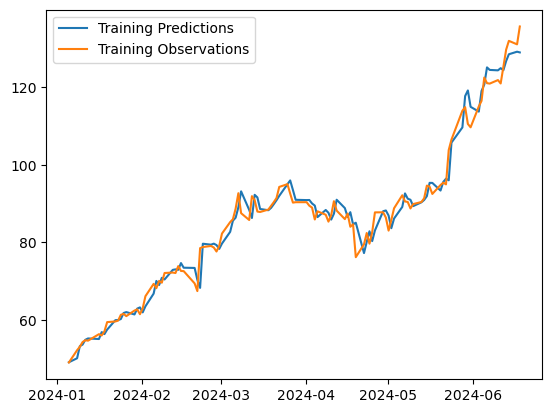

In [84]:
train_predictions = model.predict(x_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])


1/1 [==============================] - 0s 8ms/step


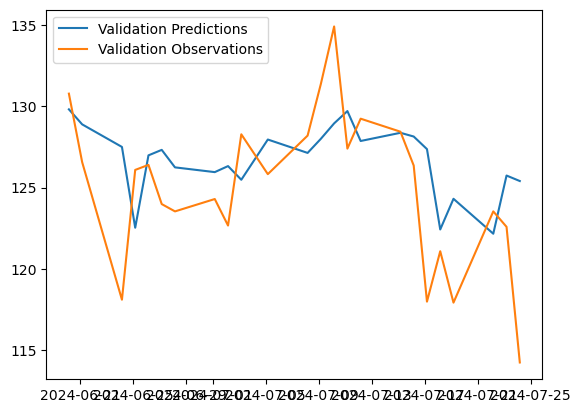

In [85]:
val_predictions = model.predict(x_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 10ms/step


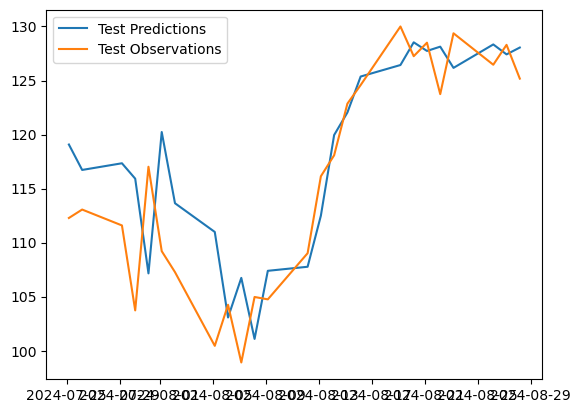

In [86]:
test_predictions = model.predict(x_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test,  y_test)
plt.legend(['Test Predictions', 'Test Observations'])

1/1 [==============================] - 0s 7ms/step


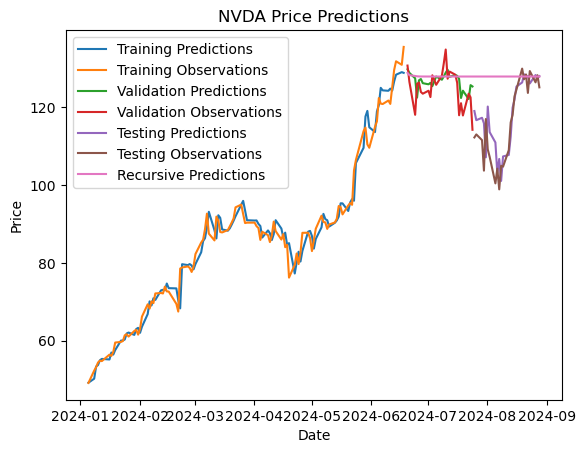

In [87]:
from copy import deepcopy
import numpy as np

recursive_predictions = []

last_window = deepcopy(x_train[-1])  # shape (3, 1)

for _ in range(len(dates_val) + len(dates_test)):
    
    # Predict next value
    next_prediction = model.predict(
        last_window[np.newaxis, :, :]
    )[0, 0]
    
    recursive_predictions.append(next_prediction)

    # Shift window left
    last_window[:-1] = last_window[1:]
    
    # 3Insert prediction at the end
    last_window[-1, 0] = next_prediction

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)

plt.plot(recursive_dates, recursive_predictions)

plt.legend([
    'Training Predictions',
    'Training Observations',
    'Validation Predictions',
    'Validation Observations',
    'Testing Predictions',
    'Testing Observations',
    'Recursive Predictions'
])

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('NVDA Price Predictions')
plt.show()



In [88]:
import numpy as np
from sklearn.metrics import mean_absolute_error

# Make sure predictions are 1D
test_pred = np.asarray(test_predictions).reshape(-1)
y_true = np.asarray(y_test).reshape(-1)

# 1) MAE (regression error)
mae = mean_absolute_error(y_true, test_pred)

# 2) Baseline: "tomorrow = last observed price in the window"
# If your x_test is shaped (samples, timesteps, features), the last observed price is:
naive_pred = x_test[:, -1, 0]
baseline_mae = mean_absolute_error(y_true, naive_pred)

# 3) Directional Accuracy (hit rate)
# Compare sign of day-to-day change in predicted vs actual
pred_dir = np.sign(test_pred[1:] - test_pred[:-1])
true_dir = np.sign(y_true[1:] - y_true[:-1])

directional_accuracy = np.mean(pred_dir == true_dir)

print(f"Test MAE: ${mae:.4f}")
print(f"Baseline MAE (predict last price): ${baseline_mae:.4f}")
print(f"Improvement vs baseline: {((baseline_mae - mae) / baseline_mae) * 100:.2f}%")
print(f"Directional Accuracy: {directional_accuracy * 100:.2f}%")


Test MAE: $4.3584
Baseline MAE (predict last price): $4.1950
Improvement vs baseline: -3.89%
Directional Accuracy: 37.50%
